# Time series forecasting.

Okay, we've learned how to do classification, save models, load models and more. Now it's time to do something real hard - predict the future. That's right, we going to use a machine learning model to predict future values of weather.

Following along with: https://www.tensorflow.org/tutorials/structured_data/time_series

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
plt.style.use('dark_background')

In [3]:
# Going to use weather data from this website.
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [4]:
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
# Oh gawd, why not juse do a resample for the average hourly values?? Gross.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [5]:
date_time

5        2009-01-01 01:00:00
11       2009-01-01 02:00:00
17       2009-01-01 03:00:00
23       2009-01-01 04:00:00
29       2009-01-01 05:00:00
                 ...        
420521   2016-12-31 19:10:00
420527   2016-12-31 20:10:00
420533   2016-12-31 21:10:00
420539   2016-12-31 22:10:00
420545   2016-12-31 23:10:00
Name: Date Time, Length: 70091, dtype: datetime64[ns]

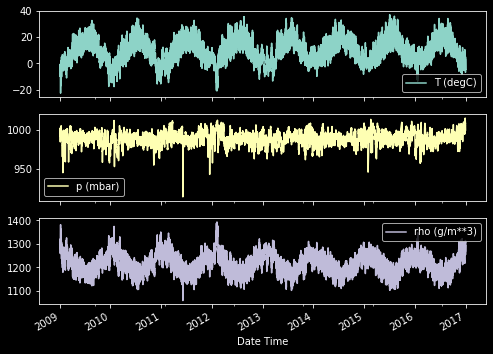

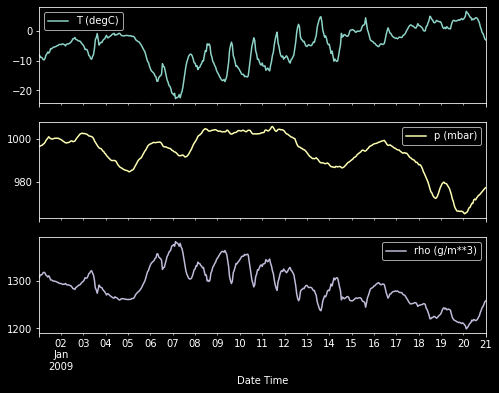

In [6]:
# Plot this out
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [8]:
df.columns

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

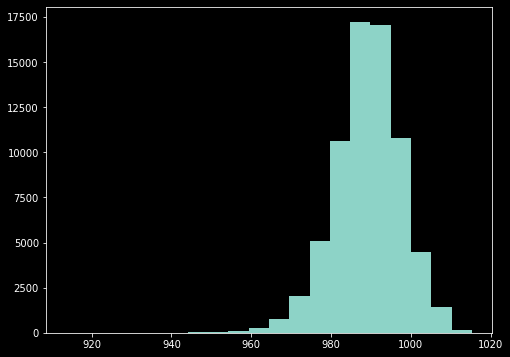

In [9]:
plt.hist(df['p (mbar)'], bins=20)
plt.show()

In [10]:
# Checking out the general statistics of the data
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [11]:
# Pull out bad_values in wind speed, set to 0
wv = df['wv (m/s)']
bad_wv = wv == -9999.0 # Get indices
wv[bad_wv] = 0.0 # Set to zero where indices are the same

# Same thing with max wx
max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

Text(0, 0.5, 'Wind Velocity [m/s]')

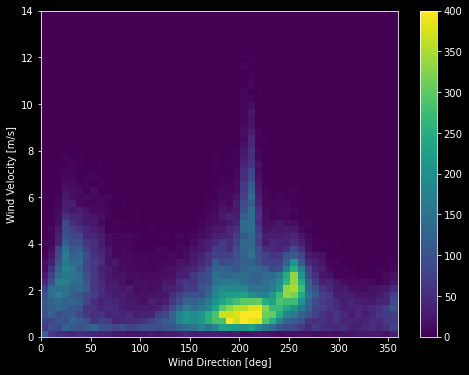

In [12]:
# Now we have an issue in the wind is direction and speed, which is not great. 
# Need to break wind into X and y components, since this makes sense to computer. 360 to 0 should be next
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [13]:
# Convert to vectors
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

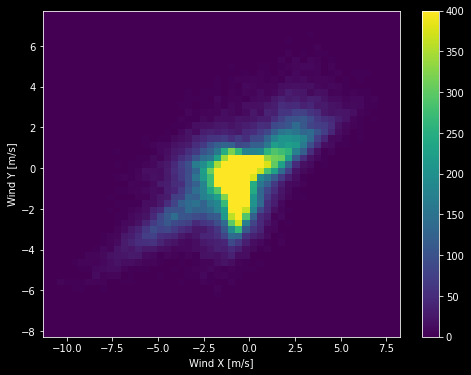

In [14]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')
plt.show()

In [15]:
# Conver time to seconds so the machine can understand better
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [16]:
# Now, we know that the time of day and the time of year are important. Currently, the model has no concept
# Of these part. Let's solve that
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

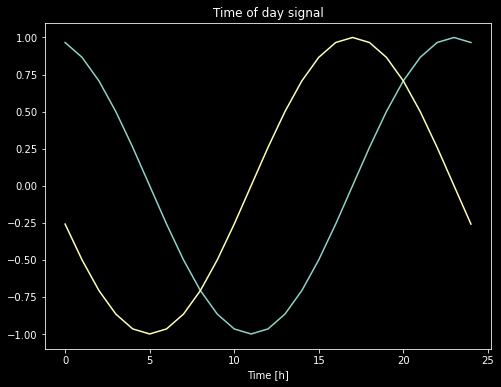

In [17]:
# Now we have a sin and cos for each day
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

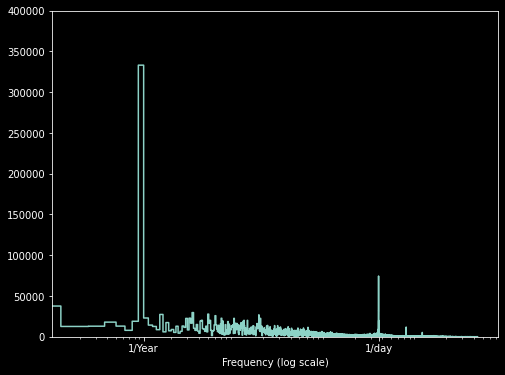

In [18]:
# Let's check the important frequencies using and fft.
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [26]:
# Spliting up the input data frame into train, validate and test (0.7, 0.2, 0.1)
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [27]:
# Normalizing the data. Find different from mean and divide by the std

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

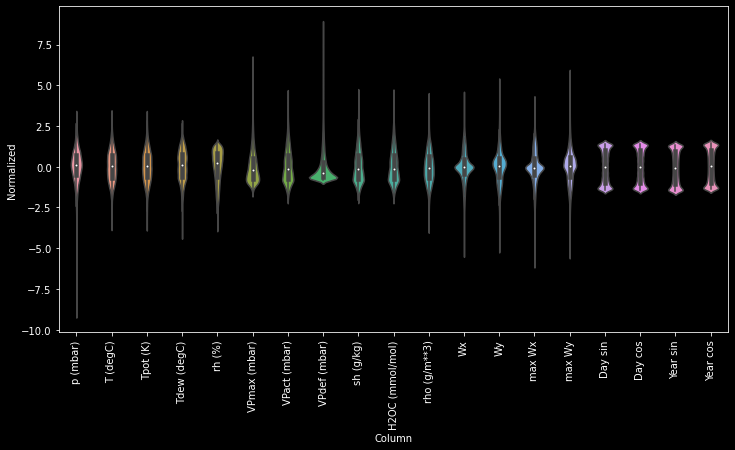

In [32]:
# Now, we can do something real fun. Since we have normalized the data, we can compare it 
# All to each other
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized') # Use this to create X,Y column pairs
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

### Timeforecasting

There are a few ways that we can do this - for outputs we can do single-output and multi-output. For inputs we can do single timestep and multi-timestep. Examples:

* single input, single output - know weather today, what is weather tomorrow
* sing input, multi output - know weather today, what is weather next week

See the website for how exactly this can be broken up. It is pretty common sense stuff

In [33]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        """
        Take the input data and breaks it up into input and output to use later
        """
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [35]:
"""
Assuming each timestamp is one hour, this is 24 hours for input with one output 24 hours in the future. 
This is shown by the fact that the label indices is number 47
"""
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [36]:
"""
6 hours of inputs predicting hour #7
"""
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [37]:
def split_window(self, features):
    """
    Break up the dataframe and return the inputs and labels. 
    """
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

# Whoah, didn't know you could add functions like this
WindowGenerator.split_window = split_window

In [42]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.xarray(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)
